# Classification of Alzhaimer through Brain MRI

## Importing Libraries

In [1]:
#Package imports.
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random
import tensorflow as tf
from keras.utils import to_categorical
from keras import layers,models,losses
from sklearn import model_selection, metrics, preprocessing

In [2]:
#Import and mount Google Drive.
from google.colab import drive
#
drive.mount("/content/drive")

Mounted at /content/drive


## Load Images

In [3]:
#Unzip the dataset file and store it in a folder called images.
#!unzip "/content/drive/MyDrive/MRI.zip" -d "/content/drive/MyDrive/images_MRI/"

In [4]:
!ls "/content/drive/MyDrive/images_MRI/Data"

'Mild Dementia'  'Moderate Dementia'  'Non Demented'  'Very mild Dementia'


In [5]:
#Read the images and get the data in a RGB and specific shape
folder_path = "/content/drive/MyDrive/images_MRI/Data/"
size = 128
data = []
labels = []
paths=[]
for folder in os.listdir(folder_path):
    for files in os.listdir(os.path.join(folder_path, folder)):
        if files.endswith("jpg"):
            labels.append(folder)
            #Create the image path.
            img_path = os.path.join(folder_path, folder, files)
            #Read in the images.
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            #Change BGR colour default from cv2 to RGB used in matplotlib.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #Resize the images.
            img = cv2.resize(img, (size, size))
            data.append(img)
            paths.append(img_path)

#Convert the data from a list to a NumPy array.
data_arr = np.array(data)

## Select by random sampling

In [6]:
#labels_np=np.array(labels)
#selected_indices={}
#for t in ['Mild Dementia','Non Demented','Very mild Dementia']:
#  selected_indices[t]=np.random.choice(np.where(labels_np==t)[0],500,replace=False)
#all_indices=np.hstack((selected_indices['Mild Dementia'],selected_indices['Non Demented'],selected_indices['Very mild Dementia'],np.where(labels_np=='Moderate Dementia')[0]))
#paths_to_delete=np.setdiff1d(np.array(paths),np.array(paths)[all_indices])
#for n in paths_to_delete:
#  os.remove(n)

## Data Analysis

In [7]:
#Check the size of the images
data_arr.shape

(1988, 128, 128, 3)

In [8]:
#Check all the classes
set(labels)

{'Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia'}

In [9]:
#Checking number of images from Mild Dementia
print('Mild Dementia:',labels.count("Mild Dementia"))
#Checking number of images from Moderate Dementia
print('Moderate Dementia:',labels.count("Moderate Dementia"))
#Checking number of images from Non Demented
print('Non Demented:',labels.count("Non Demented"))
#Checking number of images from Very mild Dementia
print('Very mild Dementia:',labels.count("Very mild Dementia"))

Mild Dementia: 500
Moderate Dementia: 488
Non Demented: 500
Very mild Dementia: 500


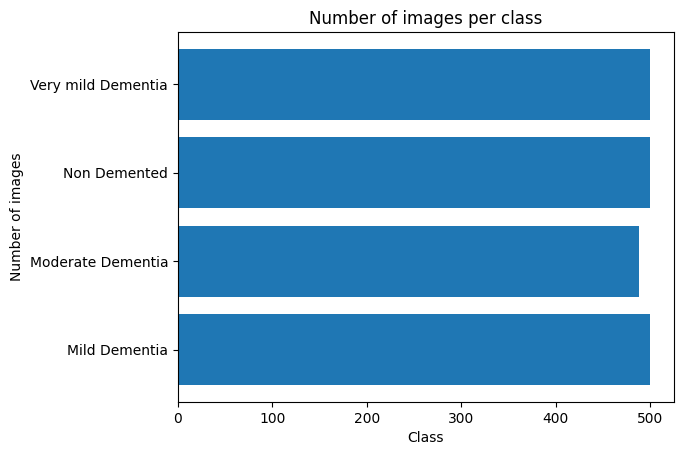

In [10]:
#Plotting horizontal barchart of the classes and images.
labels_plt=['Mild Dementia','Moderate Dementia','Non Demented','Very mild Dementia']
count=[labels.count('Mild Dementia'),labels.count('Moderate Dementia'),labels.count('Non Demented'),labels.count('Very mild Dementia')]
fig,ax=plt.subplots()
ax.barh(labels_plt,count)
ax.set_title('Number of images per class')
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
plt.show()

(-0.5, 127.5, 127.5, -0.5)

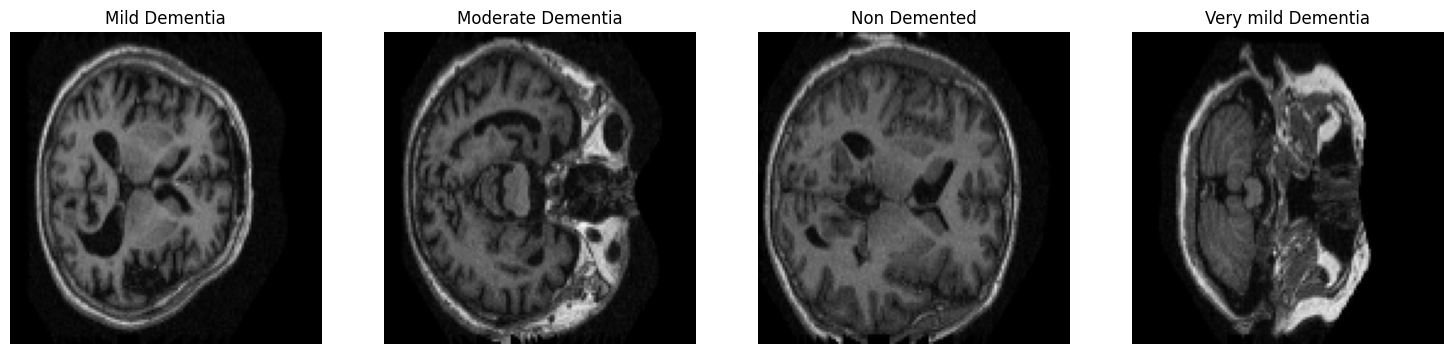

In [11]:
#Plot of examples by class of image
fig,ax=plt.subplots(1,4)
fig.set_size_inches(18.5, 10.5)
ax[0].imshow(data_arr[np.random.choice(range(1,500),1)[0]])
ax[0].set_title('Mild Dementia')
ax[0].axis('off')
ax[1].imshow(data_arr[np.random.choice(range(501,1000),1)[0]])
ax[1].set_title('Moderate Dementia')
ax[1].axis('off')
ax[2].imshow(data_arr[np.random.choice(range(1001,1500),1)[0]])
ax[2].set_title('Non Demented')
ax[2].axis('off')
ax[3].imshow(data_arr[np.random.choice(range(1501,1993),1)[0]])
ax[3].set_title('Very mild Dementia')
ax[3].axis('off')

## Preprocessing

### Create noise and data augmentation

In [12]:
#Function for create noise in the image.
def image_noise(image, noise_level):
    image = tf.cast(image, tf.int32)
    height, width, channels = image.shape[0], image.shape[1], image.shape[2]
    pixels_total = height * width * channels
    noise_added = pixels_total * noise_level
    noise_total=0
    #Get the percentage of noise
    while noise_total<noise_added:
      w=random.randint(1,3)
      h=random.randint(1,3)
      x=random.randint(1,width-w)
      y=random.randint(1,height-h)
      noise_total += w*h
      noise_to_add=w*h*3
      #Create the indices for introduce noise
      indices = [[j, k, i] for i in range(3) for j
                 in range(y, y + h) for k in range(x, x + w)]
      #Generate black noise
      noise_values = [np.random.randint(1,25)]*noise_to_add
      #Introduce noise
      image = tf.tensor_scatter_nd_update(image, indices, noise_values)
    return image

In [13]:
#Function for create noise in the image.
#def image_noise(image,noise_level):
#  height, width, channels = image.shape
#  pixels_total=height*width*channels
#  noise_added=int(pixels_total*noise_level)
#  noise_total=0
#  while noise_total<noise_added:
#    w=random.randint(1,3)
#    h=random.randint(1,3)
#    noise_total+=w*h
#    x=random.randint(0,width-w)
#    y=random.randint(0,height-h)
#    image[y:y+h,x:x+w,:]=np.random.randint(1,25)
#  return image

In [14]:
#Function for augment the images
def image_augment(image,seed):
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    #Random left flip
    image = tf.image.stateless_random_flip_left_right(
       image, seed)
    #Random brightness change
    #image = tf.image.stateless_random_brightness(
       # image, max_delta=0.1, seed=new_seed)
    #Introduce hue
    #image = tf.image.stateless_random_hue(
       # image, 0.2, seed)
    #Introduce saturation
    #image = tf.image.stateless_random_saturation(
        #image, 0.3, 1.0, seed)
    #Adjust any value to the RGB range
    image = tf.clip_by_value(image, 0, 255)
    return image

In [15]:
#Set the random seed generator
rng = tf.random.Generator.from_seed(123, alg='philox')

In [41]:
#Function to prepare the images with noise and augmentation
def image_wrapper(image):
  #Generate random independent seed
  seed=rng.make_seeds(2)[0]
  #Augment data with the random seed
  image1=image_augment(image,seed)
  #Add noise
  image2=image_noise(image1,0.07)
  return image1,image1

In [42]:
#Get dataset tensorflow type
data=tf.data.Dataset.from_tensor_slices(data_arr)

In [105]:
#Split train and test
data_train,data_test=model_selection.train_test_split(data_arr/255., test_size=0.2, random_state=42)
data_train,data_validation=model_selection.train_test_split(data_train, test_size=0.2, random_state=42)

In [106]:
#Preprocess the data
data_train_processed=tf.data.Dataset.from_tensor_slices(data_train).shuffle(100).map(image_wrapper).batch(32)
data_test_processed=tf.data.Dataset.from_tensor_slices(data_test).shuffle(100).map(image_wrapper).batch(32)
data_validation_processed=tf.data.Dataset.from_tensor_slices(data_validation).shuffle(100).map(image_wrapper).batch(32)

In [107]:
#Get data preprocessed
data_test_processed

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None))>

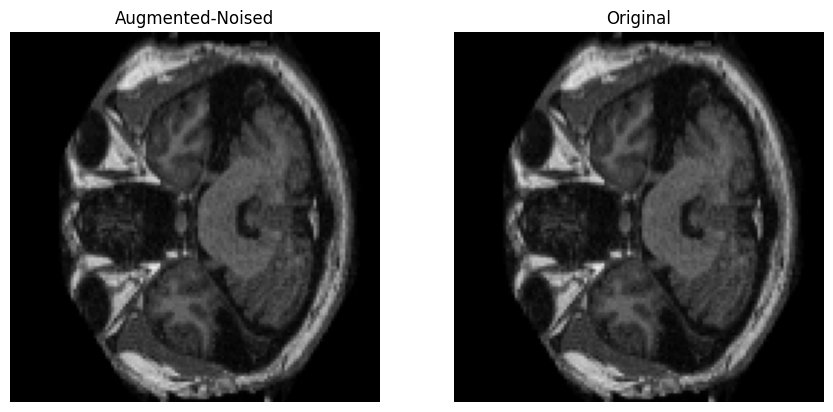

In [108]:
#Examples of
for item in data_train_processed.take(1):
    fig,ax=plt.subplots(1,2)
    fig.set_size_inches(10.5, 7.5)
    ax[0].imshow(item[0][0].numpy())
    ax[0].set_title('Augmented-Noised')
    ax[0].axis('off')
    ax[1].imshow(item[1][0].numpy())
    ax[1].set_title('Original')
    ax[1].axis('off')

## Denoising

In [109]:
single_test_original=np.expand_dims(data_arr[1]/255.,axis=0)
single_test_noise=np.expand_dims(image_noise(data_arr[1],0.07).numpy()/255.,axis=0)

### Autoencoder

In [78]:
#Basic auto encoder for denoising
#Encoder 1Conv + BatchNorm + MaxPooling
def encoder(filters):
    def apply(x):
        x=layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x=layers.BatchNormalization()(x)
        x=layers.MaxPooling2D((2,2),padding='same')(x)
        return x
    return apply

In [79]:
#Decoder 1ConvTrans + BatchNorm
def decoder(filters):
    def apply(x):
        x=layers.Conv2DTranspose(filters, (3,3), strides=2, padding='same', activation='relu')(x)
        x=layers.BatchNormalization()(x)
        return x
    return apply

In [80]:
#Auto Encoder 3Encoder + 3Decoder from 3 to 128
def autoencoder(input_shape=(128, 128, 3)):
    inputs=layers.Input(shape=input_shape)
    #Encoder
    x=encoder(32)(inputs)
    x=encoder(64)(x)
    x=encoder(128)(x)
    #Decoder
    x=decoder(128)(x)
    x=decoder(64)(x)
    x=decoder(32)(x)
    outputs=layers.Conv2D(3, (1,1), activation='sigmoid')(x)
    return models.Model(inputs, outputs)

In [82]:
#Define autoencoder and see the structure
ae=autoencoder()
ae.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_12                  │ (None, 32, 32, 128)         │         147,584 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_13                  │ (None, 64, 64, 64)          │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_14                  │ (None, 128, 128, 32)        │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_60 (Conv2D)                   │ (None, 128, 128, 3)         │              

 Total params: 334,979 (1.28 MB)

 Trainable params: 334,083 (1.27 MB)

 Non-trainable params: 896 (3.50 KB)

In [117]:
#Compile model with adam and mean squared error
ae.compile(optimizer='adam',loss='mae')

In [118]:
ae.fit(data_train_processed,epochs=10,validation_data=data_validation_processed)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 200ms/step - loss: 0.0388 - val_loss: 0.0842
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.0306 - val_loss: 0.0408
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0291 - val_loss: 0.0424
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0282 - val_loss: 0.0349
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0279 - val_loss: 0.0283
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0282 - val_loss: 0.1531
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0301 - val_loss: 0.0305
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0274 - val_loss: 0.0300
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0267 - val_loss: 0.0301
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0271 - val_loss: 0.0264


In [119]:
ae_prediction=ae.predict(single_test_noise)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


(-0.5, 127.5, 127.5, -0.5)

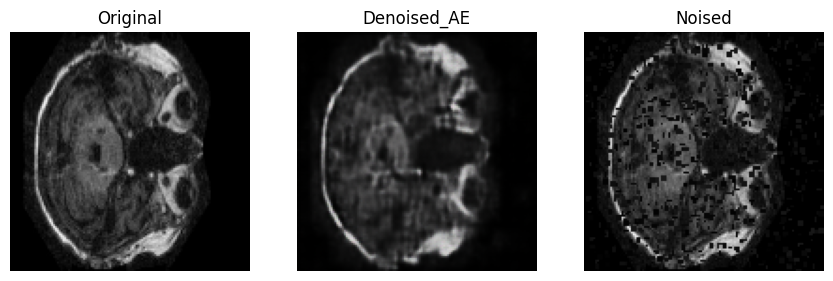

In [134]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
#fig.suptitle('Auto Encoder denoising',fontsize=16)
ax[0].imshow(test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(ae_prediction[0])
ax[1].set_title('Denoised_AE')
ax[1].axis('off')
ax[2].imshow(test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')

### U-Net

In [135]:
#U-Net for denoising images
#DoubleConv 1Conv + 1BatchNorm + 1Conv + 1BatchNorm
def unet_double_conv(filters):
    def apply(x):
        x=layers.Conv2D(filters, (3,3),padding='same',activation='relu')(x)
        x=layers.BatchNormalization()(x)
        x=layers.Conv2D(filters, (3,3),padding='same',activation='relu')(x)
        x=layers.BatchNormalization()(x)
        return x
    return apply

In [136]:
#U-Net encoder 1MaxPooling + 1DoubleConv
def unet_encoder(filters):
    def apply(x):
        x=layers.MaxPooling2D((2,2))(x)
        x=unet_double_conv(filters)(x)
        return x
    return apply

In [137]:
#U-Net decoder 1ConvTrans + 1Concatenate +1DoubleConv
def unet_decoder(filters):
    def apply(x, skip):
        x=layers.Conv2DTranspose(filters,(3,3),activation='relu',strides=2,padding='same')(x)
        x=layers.Concatenate()([x, skip])
        x=unet_double_conv(filters)(x)
        return x
    return apply

In [138]:
#U-Net from 3 to 1024 with MaxPooling
def unet(input_shape=(128, 128, 3)):
    input = layers.Input(shape=input_shape)
    # Encoder from 3 to 1024
    x1 = unet_double_conv(64)(input)
    x2 = unet_encoder(128)(x1)
    x3 = unet_encoder(256)(x2)
    x4 = unet_encoder(512)(x3)
    x  = unet_encoder(1024)(x4)
    #Decoder feom 512 to 3
    x = unet_decoder(512)(x, x4)
    x = unet_decoder(256)(x, x3)
    x = unet_decoder(128)(x, x2)
    x = unet_decoder(64)(x, x1)
    output = layers.Conv2D(3,(1,1),activation='sigmoid')(x)
    return models.Model(input,output)

In [139]:
unet=unet()
unet.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_80 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_78    │ (None, 128, 128, 64)   │            256 │ conv2d_80[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_81 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_79    │ (None, 128, 128, 64)   │            256 │ conv2d_81[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_19          │ (None, 64, 64, 64)     │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_82 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_19[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_80    │ (None, 64, 64, 128)    │            512 │ conv2d_82[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_83 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_81    │ (None, 64, 64, 128)    │            512 │ conv2d_83[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 32, 32, 128)    │              0 │ batch_normalization_8… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_84 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_82    │ (None, 32, 32, 256)    │          1,024 │ conv2d_84[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_85 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_83    │ (None, 32, 32, 256)    │          1,024 │ conv2d_85[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 34,537,027 (131.75 MB)

 Trainable params: 34,525,251 (131.70 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [140]:
unet.compile(optimizer='adam',loss='mae')

In [141]:
unet.fit(data_train_processed,epochs=10,validation_data=data_validation_processed)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - loss: 0.2204 - val_loss: 0.1459
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 60s 564ms/step - loss: 0.0851 - val_loss: 0.1268
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 564ms/step - loss: 0.0573 - val_loss: 0.1273
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 554ms/step - loss: 0.0365 - val_loss: 0.1294
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 580ms/step - loss: 0.0265 - val_loss: 0.1227
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 538ms/step - loss: 0.0235 - val_loss: 0.1124
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 575ms/step - loss: 0.0254 - val_loss: 0.1144
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 556ms/step - loss: 0.0168 - val_loss: 0.1020
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 542ms/step - loss: 0.0153 - val_loss: 0.0988
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 540ms/step - loss: 0.0162 - val_loss: 0.0773


In [142]:
unet_predicted=unet.predict(test_original)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(-0.5, 127.5, 127.5, -0.5)

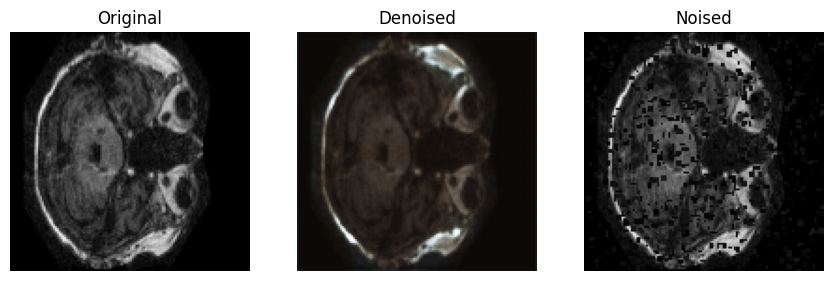

In [143]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
ax[0].imshow(test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(unet_predicted[0])
ax[1].set_title('Denoised')
ax[1].axis('off')
ax[2].imshow(test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')

In [71]:

def DoubleConv(filters):
    """Bloque de dos convoluciones + BatchNorm + ReLU"""
    def apply(x):
        x = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        return x
    return apply

def DownBlock(filters):
    """Downsampling: MaxPooling + DoubleConv"""
    def apply(x):
        x = layers.MaxPooling2D((2,2))(x)
        x = DoubleConv(filters)(x)
        return x
    return apply

def UpBlock(filters):
    """Upsampling + Concatenación con Skip Connection + DoubleConv"""
    def apply(x, skip):
        x = layers.UpSampling2D((2,2))(x)  # Interpolación x2
        x = layers.Conv2DTranspose(filters, (1,1), activation='relu')(x)  # Reduce canales
        x = layers.Concatenate()([x, skip])  # Skip Connection
        x = DoubleConv(filters)(x)  # Doble convolución
        return x
    return apply

def UNet(input_shape=(128, 128, 3)):
    """Modelo U-Net completo"""
    inputs = layers.Input(shape=input_shape)

    # Encoder (Downsampling)
    x1 = DoubleConv(64)(inputs)
    x2 = DownBlock(128)(x1)
    x3 = DownBlock(256)(x2)
    x4 = DownBlock(512)(x3)
    x  = DownBlock(1024)(x4)  # Bottleneck

    # Decoder (Upsampling con Skip Connections)
    x = UpBlock(512)(x, x4)
    x = UpBlock(256)(x, x3)
    x = UpBlock(128)(x, x2)
    x = UpBlock(64)(x, x1)

    outputs = layers.Conv2D(3, (1,1), activation='sigmoid')(x)  # Capa de salida

    return models.Model(inputs, outputs)

# Crear modelo
unet = UNet()
unet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 128, 128, 64)   │            256 │ conv2d_38[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 128, 128, 64)   │            256 │ conv2d_39[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 64, 64, 64)     │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 64, 64, 128)    │            512 │ conv2d_40[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_39    │ (None, 64, 64, 128)    │            512 │ conv2d_41[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 32, 32, 128)    │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_40    │ (None, 32, 32, 256)    │          1,024 │ conv2d_42[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_41    │ (None, 32, 32, 256)    │          1,024 │ conv2d_43[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 28,966,467 (110.50 MB)

 Trainable params: 28,954,691 (110.45 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [72]:
unet.compile(optimizer='adam',loss='mse')

In [73]:
unet.fit(data_train_processed,epochs=10,validation_data=data_test_processed)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - loss: 0.0755 - val_loss: 0.0765
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 492ms/step - loss: 0.0156 - val_loss: 0.0277
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 492ms/step - loss: 0.0068 - val_loss: 0.0297
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 496ms/step - loss: 0.0035 - val_loss: 0.0287
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 496ms/step - loss: 0.0021 - val_loss: 0.0265
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 491ms/step - loss: 0.0014 - val_loss: 0.0209
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 490ms/step - loss: 9.8325e-04 - val_loss: 0.0179
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 493ms/step - loss: 6.8399e-04 - val_loss: 0.0142
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 488ms/step - loss: 5.1755e-04 - val_loss: 0.0085
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 492ms/step - loss: 4.3086e-04 - val_loss: 0.0059


In [76]:
test_denoised=unet.predict(test_original)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


(-0.5, 127.5, 127.5, -0.5)

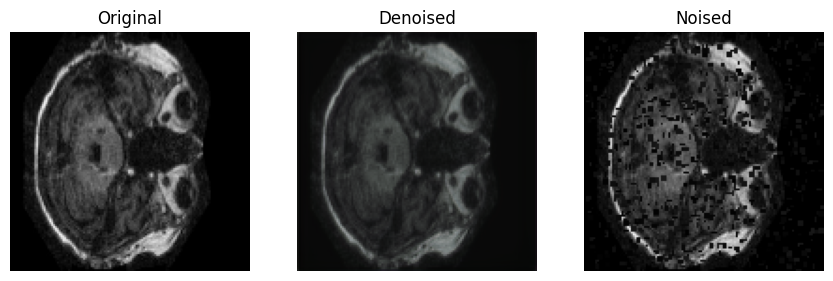

In [77]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
ax[0].imshow(test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(test_denoised[0])
ax[1].set_title('Denoised')
ax[1].axis('off')
ax[2].imshow(test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')

In [24]:

noised = layers.Input(shape=(128, 128, 3))

# Encoder
conv_1 = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=1)(noised)
batch_1 = layers.BatchNormalization()(conv_1)
conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=1)(batch_1)
batch_2 = layers.BatchNormalization()(conv_2)
max_1 = layers.MaxPooling2D((2,2), strides=2)(conv_2)

conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=1)(max_1)
batch_3 = layers.BatchNormalization()(conv_3)
conv_4 = layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=1)(batch_3)
batch_4 = layers.BatchNormalization()(conv_4)
max_2 = layers.MaxPooling2D((2,2), strides=2)(batch_4)

conv_5 = layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=1)(max_2)
batch_5 = layers.BatchNormalization()(conv_5)
conv_6 = layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=1)(batch_5)
batch_6 = layers.BatchNormalization()(conv_6)
max_3 = layers.MaxPooling2D((2,2), strides=2)(batch_6)

conv_7 = layers.Conv2D(512, (3,3), activation='relu', padding='same', strides=1)(max_3)
batch_7 = layers.BatchNormalization()(conv_7)
conv_8 = layers.Conv2D(512, (3,3), activation='relu', padding='same', strides=1)(batch_7)
batch_8 = layers.BatchNormalization()(conv_8)
max_4 = layers.MaxPooling2D((2,2), strides=2)(batch_8)

conv_9 = layers.Conv2D(1024, (3,3), activation='relu', padding='same', strides=1)(max_4)
batch_9 = layers.BatchNormalization()(conv_9)
conv_10 = layers.Conv2D(1024, (3,3), activation='relu', padding='same', strides=1)(batch_9)
batch_10 = layers.BatchNormalization()(conv_10)

# Decoder
deconv_1 = layers.Conv2DTranspose(512, (3,3), activation='relu', padding='same', strides=2)(batch_10)
concat_1 = layers.Concatenate()([conv_8, deconv_1])
conv_11 = layers.Conv2D(512, (3,3), activation='relu', padding='same', strides=1)(concat_1)
batch_11 = layers.BatchNormalization()(conv_11)

deconv_2 = layers.Conv2DTranspose(256, (3,3), activation='relu', padding='same', strides=2)(batch_11)
concat_2 = layers.Concatenate()([conv_6, deconv_2])
conv_13 = layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=1)(concat_2)
batch_13 = layers.BatchNormalization()(conv_13)

deconv_3 = layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same', strides=2)(batch_13)
concat_3 = layers.Concatenate()([conv_4, deconv_3])
conv_15 = layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=1)(concat_3)
batch_15 = layers.BatchNormalization()(conv_15)

deconv_4 = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides=2)(batch_15)
concat_4 = layers.Concatenate()([conv_2, deconv_4])
conv_17 = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=1)(concat_4)
batch_17 = layers.BatchNormalization()(conv_17)

output = layers.Conv2D(3, (1,1), activation='sigmoid', padding='same', strides=1)(batch_17)

model = models.Model(inputs=noised, outputs=output)

In [25]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse')

In [ ]:
model.fit(data_train_processed,epochs=10,validation_data=data_test_processed)

Epoch 1/10
 84/100 ━━━━━━━━━━━━━━━━━━━━ 7:37 29s/step - loss: 0.1513

In [ ]:
test_denoised=model.predict(test_noise)

In [ ]:
test_original.shape

In [ ]:
test_denoised.shape

In [ ]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
ax[0].imshow(test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(test_denoised[0])
ax[1].set_title('Denoised')
ax[1].axis('off')
ax[2].imshow(test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [50]:
conv_ae.compile(loss="mse", optimizer="nadam")
conv_ae.fit(data_train_processed, epochs=10,validation_data=data_test_processed)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - loss: 0.0394 - val_loss: 0.0259
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 205ms/step - loss: 0.0198 - val_loss: 0.0260
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 178ms/step - loss: 0.0196 - val_loss: 0.0268
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step - loss: 0.0195 - val_loss: 0.0265
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 202ms/step - loss: 0.0195 - val_loss: 0.0257
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step - loss: 0.0195 - val_loss: 0.0267
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - loss: 0.0196 - val_loss: 0.0263
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - loss: 0.0195 - val_loss: 0.0258
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - loss: 0.0194 - val_loss: 0.0261
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 180ms/step - loss: 0.0195 - val_loss: 0.0262


In [51]:
test_denoised=conv_ae.predict(test_noise)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


(-0.5, 127.5, 127.5, -0.5)

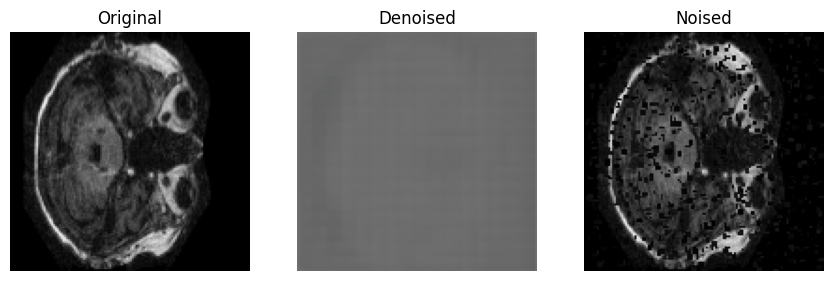

In [52]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
ax[0].imshow(test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(test_denoised[0])
ax[1].set_title('Denoised')
ax[1].axis('off')
ax[2].imshow(test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')